In [2]:
import pandas as pd
import mlflow

mlflow.set_tracking_uri("http://127.0.0.1:5001")

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2024-11-28 08:37:25.734018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-28 08:37:28.162212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
ratings = pd.read_csv('../data/ml-32m/ratings.csv')
df_users = pd.read_csv('../data/ml-32m/users.csv')
df_movies = pd.read_csv('../data/ml-32m/movies.csv')

#df_movies.loc[df_movies['IMDB URL'].isna(), 'IMDB URL'] = ''

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])

ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

ratings.head(5)

,userId,movieId,rating,timestamp
0,1,1,4.0,944249077
1,1,2,1.0,944250228
2,1,3,2.0,943230976
3,1,4,5.0,944249077
4,1,5,5.0,943228858


In [6]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [7]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

200948 84432 200948 80210


In [8]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5.0, 0.5, 3.5404047232043014)

In [11]:
#Seteo del experimento
experiment_name = "Neural Network 32 M"
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='mlflow-artifacts:/496846399806627028', creation_time=1731957405074, experiment_id='496846399806627028', last_update_time=1731957405074, lifecycle_stage='active', name='Neural Network 32 M', tags={}>

In [9]:
from keras.layers import Input, Embedding, Flatten, Dropout, Concatenate, Dense, Activation, Lambda
from keras import Model
from keras.regularizers import l2
from keras.optimizers import Adam

In [12]:
mlflow.start_run(run_name="Latent factor 5 y 5 + 20 epochs + lr 0.0009")

<ActiveRun: >

In [13]:
n_latent_factors_user = 5
mlflow.log_param("n_latent_factors_user", n_latent_factors_user)
n_latent_factors_movie = 5
mlflow.log_param("n_latent_factors_movie", n_latent_factors_movie)

5

In [14]:
movie_embedding_regularizer = 0.001
mlflow.log_param("movie_embedding_regularizer_l2", movie_embedding_regularizer)
hidden_units = 50
#dropout_1 = 0.2
#dropout_2 = 0.5
mlflow.log_param("hidden_units", hidden_units)

movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding', embeddings_regularizer = l2(movie_embedding_regularizer))(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
#movie_vec = Dropout(dropout_1)(movie_vec)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
n_latent_factors_user,name='User-Embedding')(user_input))
#user_vec = Dropout(dropout_1)(user_vec)

concat = Concatenate(name='Concat')([movie_vec, user_vec])
#concat = Dropout(dropout_1)(concat)

x = Dense(hidden_units,name='FullyConnected-1', activation='relu')(concat)
#x = Dropout(dropout_2)(x)
# x = Dense(50,name='FullyConnected-1', activation='relu')(concat)
# x = Dropout(0.5)(x)


## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
x = Dense(1, activation='sigmoid',name='Activation')(x)
x = Lambda(lambda z: (max_rating - min_rating) * z + min_rating)(x)
##

model = Model([user_input, movie_input], x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Item (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 User (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 5)         422165      ['Item[0][0]']                   
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         1004745     ['User[0][0]']                   
                                                                                              

In [16]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [17]:
lr = 0.0009
model.compile(Adam(learning_rate=lr), 'mean_squared_error', metrics=[root_mean_squared_error])
mlflow.log_param("lr", lr)

0.0009

In [18]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
checkpointer = ModelCheckpoint(filepath='weights1.hdf5', verbose=1, save_best_only=True, monitor='val_root_mean_squared_error')

In [6]:
patience = 5
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
#mlflow.log_param("early_stopping_patience", patience)

In [79]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',      # Métrica a monitorear (puede ser 'val_loss' o 'loss')
    factor=0.2,              # Factor de reducción del learning rate (e.g., reduce a la mitad)
    patience=2,              # Número de épocas sin mejora antes de reducir
    min_lr=1e-6,             # Learning rate mínimo permitido
    verbose=1                # Mostrar logs cuando se reduzca el LR
)
mlflow.log_param("reduce_lr", reduce_lr)

In [19]:
batch_size = 320
epochs = 20
mlflow.log_param("batch_size", batch_size)
mlflow.log_param("epochs", epochs)

history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    batch_size = batch_size,
                    callbacks = [checkpointer],
                    epochs=epochs, verbose=1)

Epoch 1/20
79997/80001 [============================>.] - ETA: 0s - loss: 0.7763 - root_mean_squared_error: 0.8666
Epoch 1: val_root_mean_squared_error improved from inf to 0.84722, saving model to weights1.hdf5
80001/80001 [==============================] - 312s 4ms/step - loss: 0.7763 - root_mean_squared_error: 0.8666 - val_loss: 0.7442 - val_root_mean_squared_error: 0.8472
Epoch 2/20
79997/80001 [============================>.] - ETA: 0s - loss: 0.7312 - root_mean_squared_error: 0.8385
Epoch 2: val_root_mean_squared_error improved from 0.84722 to 0.83933, saving model to weights1.hdf5
80001/80001 [==============================] - 300s 4ms/step - loss: 0.7312 - root_mean_squared_error: 0.8385 - val_loss: 0.7332 - val_root_mean_squared_error: 0.8393
Epoch 3/20
80001/80001 [==============================] - ETA: 0s - loss: 0.7201 - root_mean_squared_error: 0.8310
Epoch 3: val_root_mean_squared_error improved from 0.83933 to 0.83638, saving model to weights1.hdf5
80001/80001 [=========

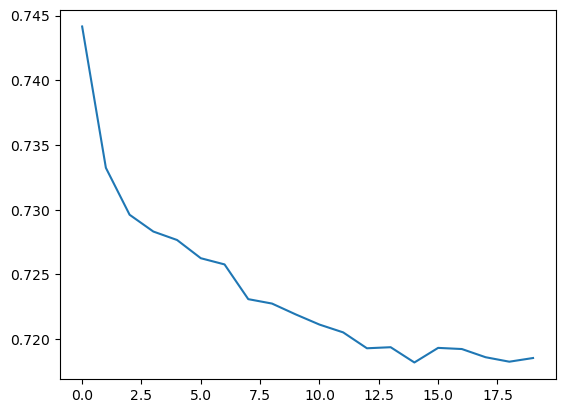

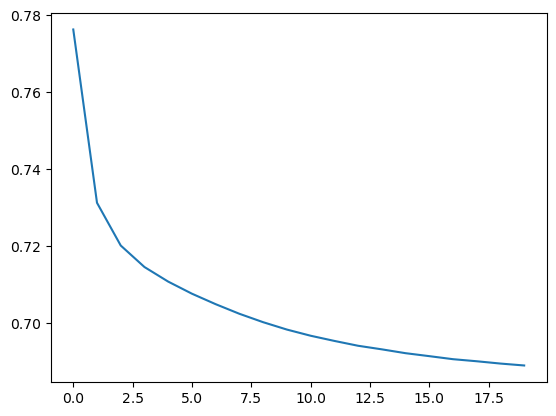

In [20]:
from matplotlib import pyplot as plt

plt.plot(history.history['val_loss'])

plt.show()
plt.plot(history.history['loss'])


In [68]:
for key, value in history.history.items():
  mlflow.log_metric(key, value[-1]) 

In [55]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

200002/200002 [==============================] - 129s 645us/step - loss: 0.7310 - root_mean_squared_error: 0.8233


[0.7309663891792297, 0.8233355283737183]

In [21]:
model.load_weights('weights1.hdf5')
mse, rmse = model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)
mlflow.log_metric("val_mse", mse) 
mlflow.log_metric("val_rmse", rmse) 

200002/200002 [==============================] - 118s 591us/step - loss: 0.7183 - root_mean_squared_error: 0.8143


In [22]:
movie_embeddings_layer = model.layers[2]
user_embeddings_layer = model.layers[3]

movie_embeddings_layer.name, user_embeddings_layer.name

('Movie-Embedding', 'User-Embedding')

In [23]:
mlflow.keras.log_model(model, "best_model")

2024/11/28 11:07:56 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/7f/19f36bv57_72qpq3mfj1x6240000gn/T/tmpbp7sy3_b/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/7f/19f36bv57_72qpq3mfj1x6240000gn/T/tmpbp7sy3_b/model/data/model/assets
2024/11/28 11:08:04 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/7f/19f36bv57_72qpq3mfj1x6240000gn/T/tmpbp7sy3_b/model, flavor: tensorflow). Fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback. 
2024/11/28 11:08:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
mlflow.end_run()

2024/11/28 11:08:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run Latent factor 5 y 5 + 20 epochs + lr 0.0009 at: http://127.0.0.1:5001/#/experiments/496846399806627028/runs/b71f39b1935a401c9a207a2946cc4739.
2024/11/28 11:08:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5001/#/experiments/496846399806627028.


#### Hay una diferencia de 1 entre n_movies, n_users y  el shape de las matrices de embeddigs

In [25]:
movie_embeddings_matrix = movie_embeddings_layer.get_weights()[0]
user_embeddings_matrix = user_embeddings_layer.get_weights()[0]

movie_embeddings_matrix.shape, user_embeddings_matrix.shape, n_movies, n_users

((84433, 5), (200949, 5), 84432, 200948)

In [26]:
import numpy as np

np.save('../data/vector_db/movie_embeddings_matrix_1.npy', movie_embeddings_matrix)
np.save('../data/vector_db/user_embeddings_matrix_1.npy', user_embeddings_matrix)
np.save('../data/vector_db/user2Idx_1.npy', user2Idx)
np.save('../data/vector_db/movie2Idx_1.npy', movie2Idx)